# Hierarchical A* Exploration
based on The [Generalized A* Architecture by Felzenszwalb and McAllester](https://cs.brown.edu/people/pfelzens/papers/astar.pdf)

In [1]:
from collections import namedtuple
from dataclasses import dataclass
from enum import Enum
import heapq as heap
from copy import copy
from typing import Optional, List
import numpy as np
from IPython.display import HTML


from large_gcs.graph.incremental_contact_graph import IncrementalContactGraph
from large_gcs.graph.contact_graph import ContactGraph
from large_gcs.graph.graph import ShortestPathSolution, Graph
from large_gcs.graph_generators.contact_graph_generator import ContactGraphGeneratorParams
from large_gcs.graph.factored_collision_free_graph import FactoredCollisionFreeGraph

In [2]:
import logging
logging.basicConfig(level=logging.ERROR)
logging.getLogger("drake").setLevel(logging.ERROR)

Want to start with a simple example, trichal4

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-01


100%|██████████| 67/67 [00:00<00:00, 7016.86it/s]


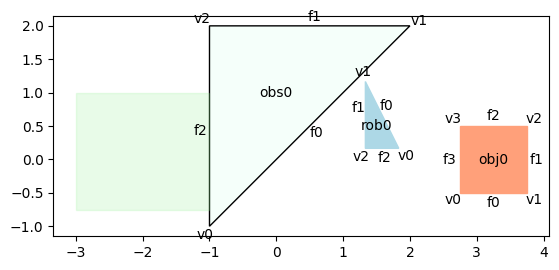

In [3]:
graph_name = "cg_trichal4"
graph_file = ContactGraphGeneratorParams.inc_graph_file_path_from_name(graph_name)
cg_inc = IncrementalContactGraph.load_from_file(graph_file, should_add_gcs=True)
cg_inc.target_name
cg_inc.plot()

In [ ]:
cg_inc.vertex_names
cg_inc.target_name

Level 1: CFree path of object (bodies with goal)
Level 0: Full dimensional

In [ ]:
graphs = []
# Define level 0 graph
graphs.append(cg_inc)
# Define level 1 graph
# Right now the body is hardcoded and limited to one, soon we will extend this to multiple bodies.
body = graphs[0].objects[0]
cg_factored_cfree = FactoredCollisionFreeGraph(
                    movable_body=body,
                    static_obstacles=graphs[0].obstacles,
                    source_pos=graphs[0].source_pos[0],
                    # target_pos=graphs[0].target_pos[0],
                    target_region_params=graphs[0].target_region_params[0],
                    cost_scaling=1.0,
                    workspace=graphs[0].workspace,
                    add_source_set=True,)
graphs.append(cg_factored_cfree)
graphs[1].plot()
print(graphs[1].source_name)

In [ ]:
graphs[1].edge_keys

In [ ]:


class GeneralizedStatementType(Enum):
    STATEMENT = 0
    CONTEXT = 1

@dataclass
class GCSHANode:
    priority: Optional[float]
    abs_level: int
    vertex_name: str
    path: list
    weight: Optional[float]
    type: GeneralizedStatementType
    parent: Optional['GCSHANode'] = None
    sol: Optional[ShortestPathSolution] = None
    
    @property
    def context_id(self) -> str:
        node = copy(self)
        node.type = GeneralizedStatementType.CONTEXT
        return node.id
        
    @property
    def id(self):
        return f"{self.abs_level}_{self.type.name}_{self.vertex_name}"
    
    def __lt__(self, other):
        return self.priority < other.priority

@dataclass
class StatementNode(GCSHANode):
    type: GeneralizedStatementType = GeneralizedStatementType.STATEMENT

    def __post_init__(self):
        # super().__post_init__()
        pass

    @classmethod
    def from_parent(cls, child_vertex_name: str, parent: 'GCSHANode'):
        assert parent.type == GeneralizedStatementType.STATEMENT
        return cls(priority=None, abs_level=parent.abs_level, vertex_name=child_vertex_name, 
                   path=parent.path + [(parent.vertex_name, child_vertex_name)],
                   weight=None, parent=parent)

@dataclass
class ContextNode(GCSHANode):
    # Each entry corresponds to vertex_cost(u) + edge_cost(u, v) for (u,v) in path that shares the same index
    path_costs: List[float] = None
    type: GeneralizedStatementType = GeneralizedStatementType.CONTEXT

    def __post_init__(self):
        # super().__post_init__()
        pass
    

In [ ]:
from large_gcs.cost_estimators.factored_collision_free_ce import FactoredCollisionFreeCE

def abs_full_problem(n: GCSHANode) -> List[GCSHANode]:
    assert n.type == GeneralizedStatementType.STATEMENT
    new_abs_level = n.abs_level + 1
    abstract_nodes = []
    # HACK find a better way to handle this case/feed this info in.
    if n.vertex_name == graphs[0].target_name:
        split_names = [graphs[1].target_name]
    else:
        split_names = FactoredCollisionFreeCE._convert_to_cfree_vertex_names(n.vertex_name)
    for name in split_names:
        # Temporary HACK, filter out robot sets (and we know they are all grouped together after object sets)
        if "rob" in name:
            break
        abstract_nodes.append(
            GCSHANode(priority=None, abs_level=new_abs_level,
                      vertex_name=name, weight=None, path=[], type=GeneralizedStatementType.STATEMENT))
    return abstract_nodes

def abs_factored_cfree_bodies_with_goals(n: GCSHANode) -> List[GCSHANode]:
    assert n.type == GeneralizedStatementType.STATEMENT
    new_abs_level = n.abs_level + 1
    new_vertex_name = "ShortcutEdge"
    return [GCSHANode(priority=None, abs_level=new_abs_level, vertex_name=new_vertex_name, weight=0, path=[], type=GeneralizedStatementType.STATEMENT)]

abs_fns = [abs_full_problem, abs_factored_cfree_bodies_with_goals]

In [ ]:
abs_full_problem(GCSHANode(priority=None, abs_level=0, vertex_name="target", weight=None, path=[], type=GeneralizedStatementType.STATEMENT))

In [ ]:
# Test the abs function
print(graphs[1].vertex_names[0])
factored_cfree_vertex_name = graphs[1].vertex_names[0]
test_factored_cfree_node = GCSHANode(priority=None, abs_level=1, vertex_name=factored_cfree_vertex_name, weight=None, path=[], type=GeneralizedStatementType.STATEMENT)
print(abs_fns[1](test_factored_cfree_node))

print()
print(graphs[0].vertex_names[2])
full_problem_vertex_name = graphs[0].vertex_names[2]
test_full_problem_node = GCSHANode(priority=None, abs_level=0, vertex_name=full_problem_vertex_name, weight=None, path=[], type=GeneralizedStatementType.STATEMENT)
print(abs_fns[0](test_full_problem_node))

In [ ]:
class GcsHAstarConvexRestriction():
    def __init__(self, graphs: List[ContactGraph], abs_fns):
        self._graphs = graphs
        self._abs_fns = abs_fns
        self._S: dict[str, GCSHANode] = {}
        self._Q: list[GCSHANode] = [] # priority queue
        max_abs_level = len(graphs)
        shotcut_edge_node = GCSHANode(priority=0, abs_level=max_abs_level, 
                                      vertex_name="ShortcutEdge", path=[], weight=0,
                                      type=GeneralizedStatementType.STATEMENT)
        # n0 = GCSHANode(priority=0, abs_level=max_abs_level, vertex_name=graphs[max_abs_level].source_name, path=[], weight=0, type=GeneralizedStatementType.STATEMENT)
        heap.heappush(self._Q, shotcut_edge_node)

        # Compile targets at each level of abstraction
        self._targets = {i: graphs[i].target_name for i in range(len(graphs))}
        self._targets[max_abs_level] = "ShortcutEdge"
        self._sources = {i: graphs[i].source_name for i in range(len(graphs))}
        print(f"targets: {self._targets}")
        # print(self._sources)

        self._iteration = 0
    
    def run(self):
        sol = None
        while sol == None and len(self._Q) > 0:
            sol = self._run_iteration()
        if sol is None:
            print(f"Gcs HA* Convex Restriction failed to find a path to the target.")
            return

        g = self._graphs[0]
        g._post_solve(sol)
        print(f"Gcs HA* Convex Restriction complete! \ncost: {sol.cost}, time: {sol.time}\nvertex path: {np.array(sol.vertex_path)}")
        
    
    def _run_iteration(self):
        self._iteration += 1
        print(f"\niteration: {self._iteration}")
        print(f"S {[(key, val.weight) for (key, val) in self._S.items()]}")
        # Make a copy of the priority queue.
        pq_copy = copy(self._Q)
        # Pop the top 10 items from the priority queue copy.
        bottom_10 = []
        for _ in range(min(10, len(pq_copy))):
            n = heap.heappop(pq_copy)
            bottom_10.append((n.id, n.priority))
        print(f"Lowest 10 in Q: {bottom_10}")

        n: GCSHANode = heap.heappop(self._Q)
        print(f"{n.id} popped off Q")
        # if n.id in self._S:
        #     if n.weight < self._S[n.id].weight:
        #         print(f"new node has lower weight, updating")
        #     else:
        #         print(f"already in S with a lower weight, continuing")
        #         return
        if n.id in self._S and n.abs_level < 1: # Only revisit nodes at level 1 or higher
            if n.weight < self._S[n.id].weight:
                print(f"new node has lower weight, updating")
            else:
                print(f"already in S with a lower weight, continuing")
                return
        self._S[n.id] = n

        if n.type == GeneralizedStatementType.STATEMENT:
            # Check if BASE rule applies (the goal of a level is reached)
            if n.vertex_name == self._targets[n.abs_level]:
                print(f"Goal reached at level {n.abs_level}")
                self._execute_base_rule(n)
                if n.abs_level == 0:
                    return n.sol
                else:
                    return None

            # Generate neighbors (vertices and edges) that you are about to explore
            # print(f"generating neighbors for {n.vertex_name}")
            self._graphs[n.abs_level].generate_neighbors(n.vertex_name)
            # Get UP rules (edges at the same level)
            edges = graphs[n.abs_level].outgoing_edges(n.vertex_name)

            for edge in edges:
                neighbor_in_path = any(
                        (u == edge.v or v == edge.v) for (u, v) in n.path
                    )
                if not neighbor_in_path:
                # if edge.v not in self._S: # No reexploring
                    neighbor = StatementNode.from_parent(child_vertex_name=edge.v, parent=n)
                    abs_neighbor_nodes = self._abs_fns[n.abs_level](neighbor)
                    # print(f"neighbor: {neighbor.id}")
                    # print(f"abs neighbor nodes: {np.array([(abs_n.id, abs_n.context_id in self._S)  for abs_n in abs_neighbor_nodes])}")
                    # Check if all required contexts of the abstracted neighbor are in S
                    if all([abs_n.context_id in self._S for abs_n in abs_neighbor_nodes]):
                        self._execute_up_rule(neighbor)
                    else:
                        print(f"required contexts for {neighbor.id} not in S , continuing")

        # CONTEXT and has other statements in path to convert to contexts
        elif n.type == GeneralizedStatementType.CONTEXT:
            if len(n.path) > 0:
                # Get DOWN rules
                # Go back one step along the path that was taken to calculate its context
                self._execute_down_rule(n_antecedent=n)
            else:
                # The context for the source node has been added to S, so we can now add the source node to Q
                self._execute_source_up_rule(n)

    def _execute_base_rule(self, n_antecedent: StatementNode):
        print(f"Executing BASE rule for antecendent {n_antecedent.id}")
        # The antecedent will always be a goal node.
        
        # Extract path costs
        path_costs = []
        if len(n_antecedent.path) > 0:
            original_g: ContactGraph = self._graphs[n_antecedent.abs_level]
            print(f"original sol cost: {n_antecedent.sol.cost}")
            # WORKAROUND individual costs not being available in solve convex restriction result.
            # Create as new graph with just the path from the source to the goal and solve that as a full problem
            temp_g = Graph()
            temp_g.add_vertex(original_g.source, original_g.source_name)
            for (u, v) in n_antecedent.path:
                temp_g.add_vertex(original_g.vertices[v], v)
                temp_g.add_edge(original_g.edges[(u, v)])
            temp_g.set_source(original_g.source_name)
            temp_g.set_target(original_g.target_name)
            sol = temp_g.solve_shortest_path()
            print(f"temp sol cost: {sol.cost}")
            n_antecedent.sol = sol
            g = temp_g
            
            for e in n_antecedent.path:
                vertex_cost = g.vertices[e[1]].gcs_vertex.GetSolutionCost(n_antecedent.sol.result)
                edge_cost = g.edges[e].gcs_edge.GetSolutionCost(n_antecedent.sol.result)
                path_costs.append(vertex_cost + edge_cost)
            print(f"path: {sol.vertex_path}")
            print(f"path costs: {path_costs}")
            print(f"total cost: {sum(path_costs)}")
        n_next = ContextNode(
            # Priority of the context is the weight of the statement
            priority=n_antecedent.weight,
            # Weight of the context of the goal statement is 0
            weight=0,
            abs_level=n_antecedent.abs_level,
            vertex_name=n_antecedent.vertex_name,
            path=n_antecedent.path,
            path_costs=path_costs,
            sol=n_antecedent.sol,
        )
        heap.heappush(self._Q, n_next)
    
    def _execute_down_rule(self, n_antecedent: ContextNode):
        print(f"Executing DOWN rule for antecedent {n_antecedent.id}")
        
        child = ContextNode(
            # Slightly confused about the priority, need to think through
            priority=n_antecedent.sol.cost,
            abs_level=n_antecedent.abs_level,
            vertex_name=n_antecedent.path[-1][0], 
            # Weight of the prior context is parent's weight + vertex cost and edge cost (stored in path_costs)
            weight=n_antecedent.weight + n_antecedent.path_costs[-1],
            path=n_antecedent.path[:-1],
            path_costs=n_antecedent.path_costs[:-1],
            sol=n_antecedent.sol,
            parent=n_antecedent)
        
        heap.heappush(self._Q, child)
    
    def _execute_source_up_rule(self, n_antecedent: ContextNode):
        print(f"Executing SOURCE UP rule for antecedent {n_antecedent.id}")
        lower_abs_level = n_antecedent.abs_level - 1
        source_name = self._graphs[lower_abs_level].source_name
        # add the source node of the next level to the queue
        n_source = StatementNode(
                    priority=n_antecedent.priority, # We want this to get popped off immediately after the context above is popped off
                    abs_level=lower_abs_level,
                    vertex_name=source_name,
                    path=[],
                    weight=0,
                    type=GeneralizedStatementType.STATEMENT)
        heap.heappush(self._Q, n_source)

    
    def _execute_up_rule(self, n_conclusion: GCSHANode):
        print(f"Executing UP rule for conclusion {n_conclusion.id}")
        g: ContactGraph = self._graphs[n_conclusion.abs_level]
        abs_fn = self._abs_fns[n_conclusion.abs_level]

        # Solve convex restriction on the path from the source to the conclusion to get the weight
        g.set_target(n_conclusion.vertex_name)
        sol = g.solve_convex_restriction(n_conclusion.path)
        g.set_target(self._targets[n_conclusion.abs_level])
        if not sol.is_success:
            print(f"Convex restriction failed for {n_conclusion.id} (Conclusion invalid)")
            # Conclusion invalid, do nothing, don't add to Q
            return
        n_conclusion.sol = sol
        n_conclusion.weight = sol.cost
        abs_nodes = abs_fn(n_conclusion)
        n_conclusion.priority = n_conclusion.weight
        for abs_node in abs_nodes:
            abs_context = self._S[abs_node.context_id]
            # Calculate rule_weight (transition cost)
            # TODO Implement 
            rule_weight = 0
            n_conclusion.priority += rule_weight + abs_context.weight
        heap.heappush(self._Q, n_conclusion)


In [ ]:
alg = GcsHAstarConvexRestriction(graphs, abs_fns)
alg.run()

In [ ]:
anim = graphs[0].animate_solution()
HTML(anim.to_html5_video())

## Diagnosing why GCS HA* doesn't find a path to the target.

Bug 1

At iteration 19, when 0_STATEMENT_source is expanded, it has only one neighbor, 0_STATEMENT_('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0'). That makes sense.

At iteration 20, when 0_STATEMENT_('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0') is expanded, it does not find any neighbors... This does not make sense, there should be many neighboring sets which get abstracted to a set that already has a context in S... Investigate this!

Ok, this was a caused by a bug which was getting the outgoing edges before generating the neighbors in the graph. That is fixed, but the algorithm still isn't finding 

Now it fails at iteration 215

Tracing the solution found by the shortcut edge heuristic,
- ["source", [in S]
- "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0')"," [iter]
- ('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f2-rob0_f2')", [iter 21]
- "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f1-rob0_f1')",
- "('IC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f1-rob0_f1')", [put into Q iter 38 (but not with the above as parent)]
- "('IC|obs0_v0-obj0_f2', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f1-rob0_f1')", [never put into Q, because required context never put into S]
  - The abs of C is 1_STATEMENT_('IC|obs0_v0-obj0_f2',), note that this is a critical mode on the path to the goal.
    - it's popped off Q at iter 9, so why doesn't its context ever get put into S, I guess it's because to reach the goal, it will need to go through a set that has already been expanded (in level 1). Lets try allowing for reexpansions, and see what happens
- "('IC|obs0_v0-obj0_f2', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f1-rob0_f1')",
- "('NC|obs0_f2-obj0_f1', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f1-rob0_f1')",
- "('NC|obs0_f2-obj0_f1', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f0-rob0_v1')",
- "('NC|obs0_f2-obj0_f1', 'NC|obs0_f2-rob0_v0', 'IC|obj0_f0-rob0_v1')",
- "target"]

Need to figure out why 1_CONTEXT_('IC|obs0_v0-obj0_f2',) is never put into S, related to this is how the algorithm handles infeasibility of high level plans.

With allowing revisits at level 1, it finds a path, and only through 9 sets, which is pretty good! In fact I think it might be optimal


## Correspondences between HA\*LD terminology and GCSHA\* terminology
1. "Statement" -> convex set/ vertex in a GCS
2. "Rule" -> edge or path that gets you from one set to another set within the graph
3. Context(C) -> cost to go from set C to target
4. BASE Rule -> When the goal at a particular level has been reached, putting Context(goal) into the Q so that the DOWN Rule at the next lower level of abstraction gets fired.
5. DOWN Rule -> Referencing context of current set (current node), put parent node (context of earlier set along path to the goal) onto the Q.
6. UP Rule -> From a particular set C, explore edges to neighbors (putting neighboring sets into the Q), with weight = cost to come to neighbor (convex restriction through C to neighbor) + Context(abs(neighbor))
   1. Note: When this is fired, Context(abs(neighbor)) should already be in S (visited set). (Is this true? Or it seems like depending on the path that was found in the more abstract level, not every neighbor would have their context already in S, I think I might need another data structure, dictionary(?) of rules that are waiting to execute that are stalled because they are missing the context of the one higher level, need to think through this.)

In [4]:
from large_gcs.algorithms.gcs_hastar import GcsHAstar
from large_gcs.abstraction_models.contact_two import ContactTwo

abs_model = ContactTwo().generate(cg_inc)
reexplore_levels = ["NONE", "FULL"]
gcs_hastar = GcsHAstar(abs_model, reexplore_levels)



100%|██████████| 22/22 [00:00<00:00, 7252.59it/s]


In [5]:
gcs_hastar.run()

RuntimeError: Cycle detected in path ['source'
 "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0')"
 "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f3-rob0_v0')"
 "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f2-rob0_f2')"]
[['source'
  "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0')"]
 ["('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0')"
  "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f3-rob0_v0')"]
 ["('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f3-rob0_v0')"
  "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f2-rob0_f2')"]
 ["('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f2-rob0_f2')"
  "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f3-rob0_v0')"]]